Credit to the original authors before I modified it: https://github.com/ndahlquist/pytorch-fourier-feature-networks

<a href="https://colab.research.google.com/github/ndahlquist/pytorch-fourier-feature-networks/blob/notebook/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, let's try fitting a function to produce the image as a function of (X,Y) image coordinates. We'll start with the naive approach, and then introduce the Gaussian Fourier Feature mapping.

This is a Pytorch adaptation of the original notebook here: https://github.com/tancik/fourier-feature-networks/blob/master/Demo.ipynb.

In [1]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from rp import *
from tqdm.notebook import tqdm as tqdm

### Learnable Images

In [2]:
from source.learnable_textures import LearnableImageFourier as LearnableImageViaFourierFeatures
from source.learnable_textures import LearnableImageMLP     as LearnableImageViaSimpleMLP

### Running Tests

In [3]:
def run_test(learner='fourier',
             mapping_size=128,
             hidden_dim=256,
             scale=10,
             iter_per_epoch=100,
             num_epochs=4):
    assert learner in 'fourier simple'.split()
    
    def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
        tensor = tensor * 256
        tensor[tensor > 255] = 255
        tensor[tensor < 0] = 0
        tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

        return tensor

    def get_image():
        image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
        img = imageio.imread(image_url)[..., :3] / 255.
        c = [img.shape[0] // 2, img.shape[1] // 2]
        r = 256
        img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]

        return img
    # Note: this can be done outside of the training loop, since the result at this stage is unchanged during the course of training.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # Get an image that will be the target for our model.
    target = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
    print('Target:')
    display_image(tensor_to_numpy(target[0]))
    
    if learner=='simple':
        x=LearnableImageViaSimpleMLP(512,512,hidden_dim=hidden_dim,device=device)
    else:
        x=LearnableImageViaFourierFeatures(512,
                                            512,
                                            mapping_size=mapping_size,
                                            hidden_dim=hidden_dim,
                                            scale=scale,
                                            device=device)
    
    optimizer = torch.optim.Adam(list(x.parameters()), lr=1e-4)

    for epoch in tqdm(range(num_epochs*iter_per_epoch)):
        optimizer.zero_grad()

        generated = x()

        loss = torch.nn.functional.l1_loss(target, generated)

        loss.backward()
        optimizer.step()

        if epoch % iter_per_epoch == 0:
            print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
            display_image(tensor_to_numpy(generated[0]))

cuda
Target:


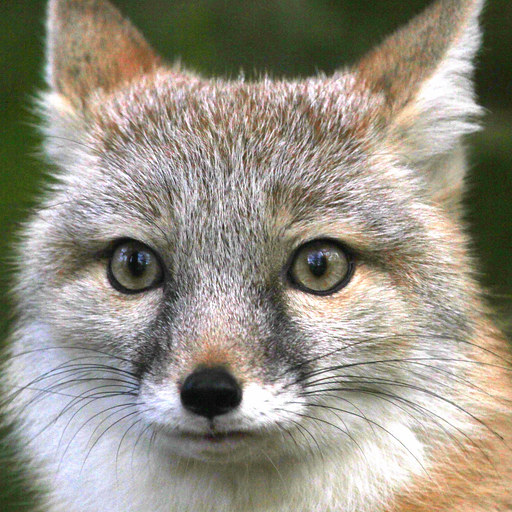

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, loss = 0.235


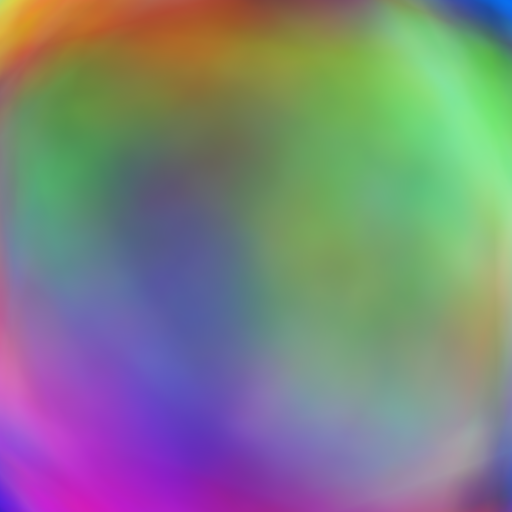

Epoch 100, loss = 0.090


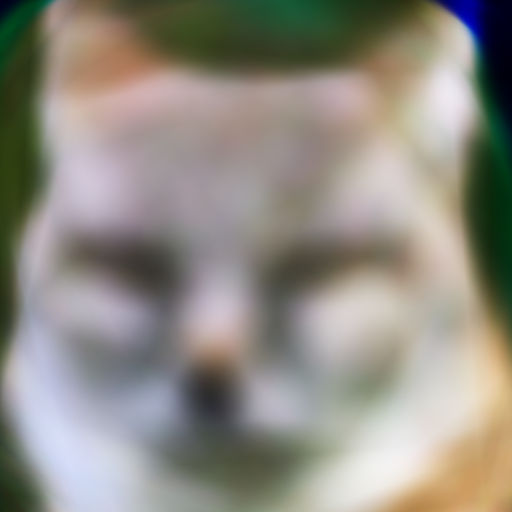

Epoch 200, loss = 0.085


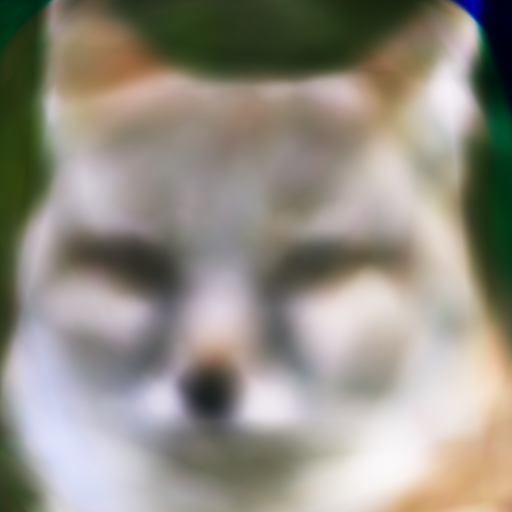

Epoch 300, loss = 0.074


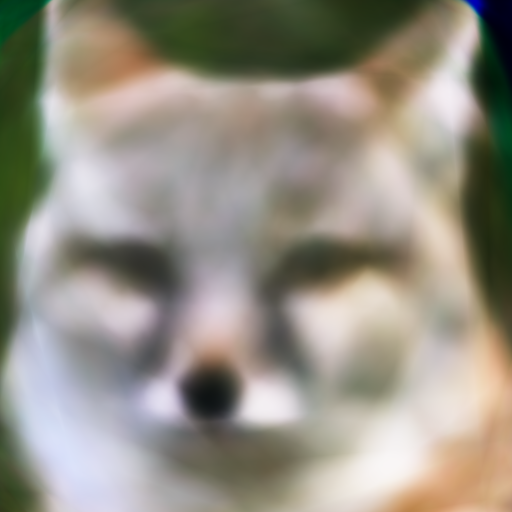

In [4]:
run_test('simple',hidden_dim=1024,iter_per_epoch=100,num_epochs=4)

cuda
Target:


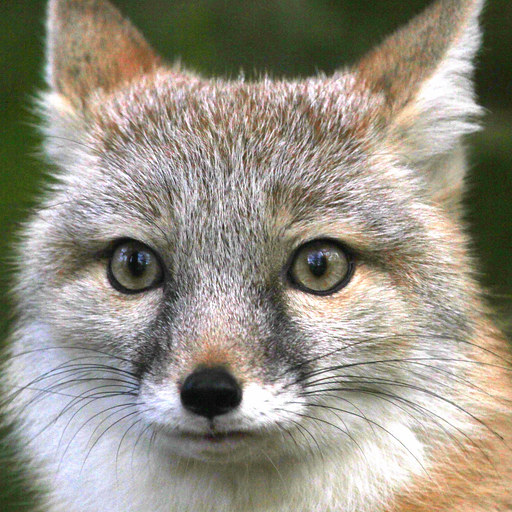

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, loss = 0.233


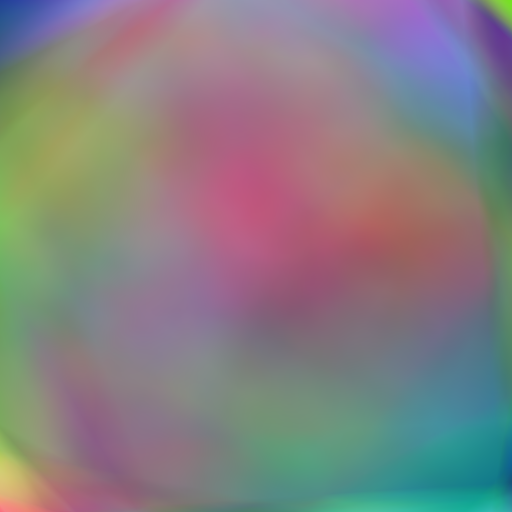

Epoch 100, loss = 0.105


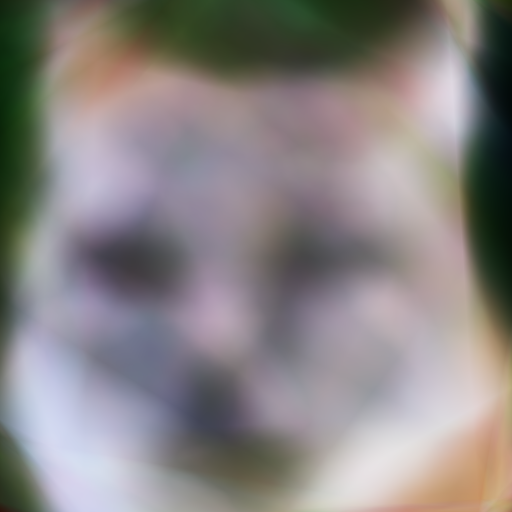

Epoch 200, loss = 0.086


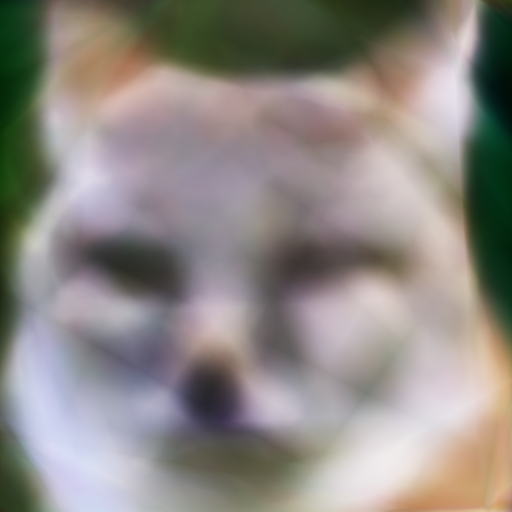

Epoch 300, loss = 0.077


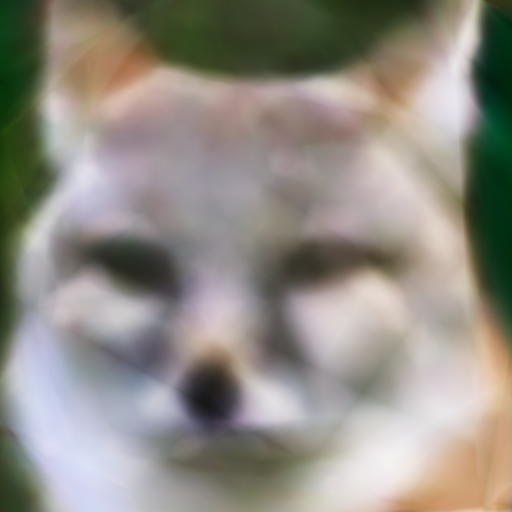

In [5]:
run_test('simple',hidden_dim=256,iter_per_epoch=100,num_epochs=4)

cuda
Target:


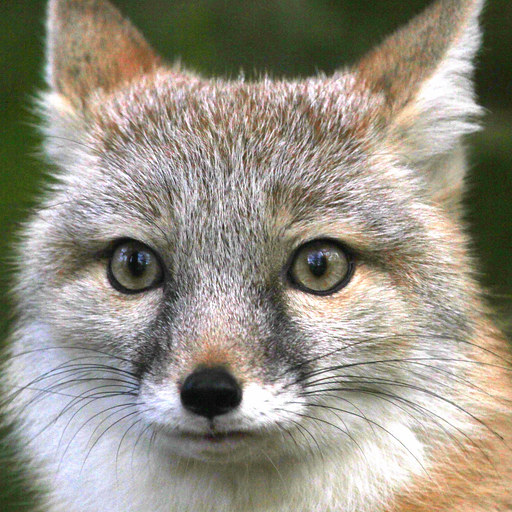

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, loss = 0.258


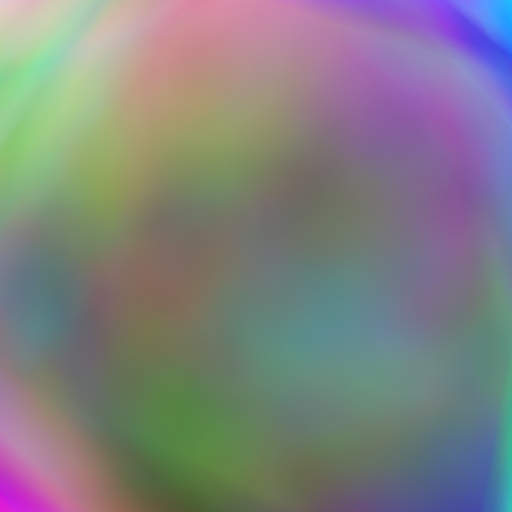

Epoch 100, loss = 0.112


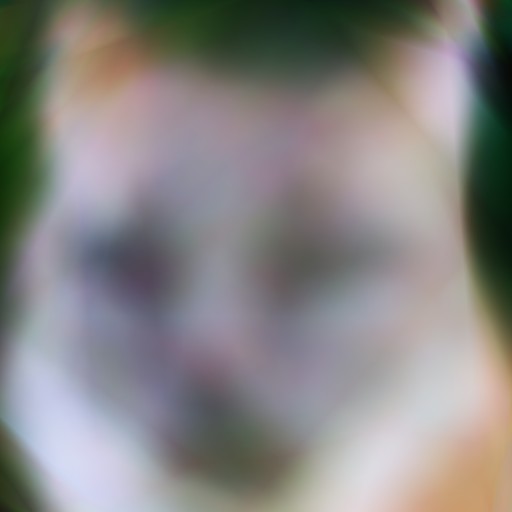

Epoch 200, loss = 0.090


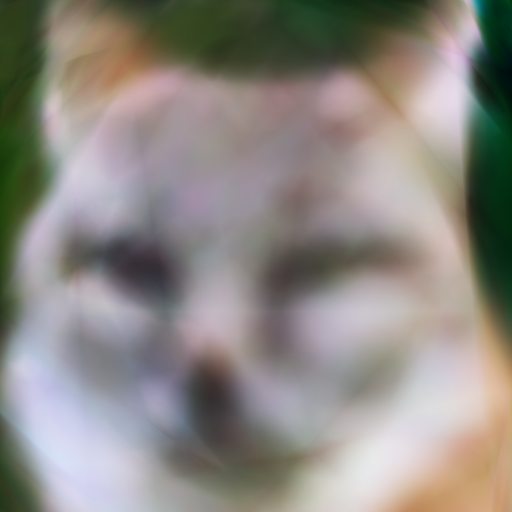

Epoch 300, loss = 0.079


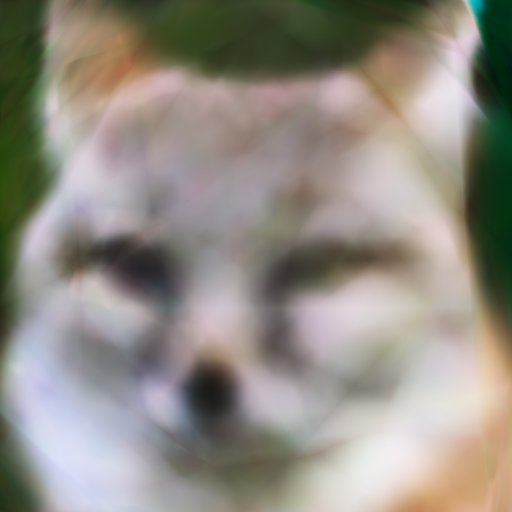

In [6]:
run_test('simple',mapping_size=128,hidden_dim=256,scale=1,iter_per_epoch=100,num_epochs=4)

cuda
Target:


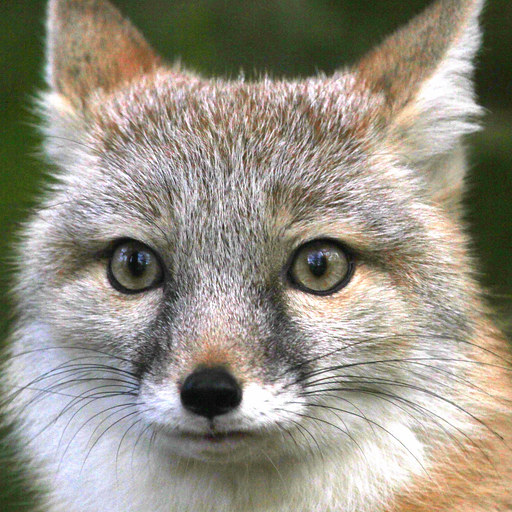

  0%|          | 0/700 [00:00<?, ?it/s]

/tmp/ipykernel_27181/3784644306.py:51: UserWarning: Using a target size (torch.Size([512, 512, 3])) that is different to the input size (torch.Size([1, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.l1_loss(target, generated)


RuntimeError: The size of tensor a (512) must match the size of tensor b (3) at non-singleton dimension 3

In [7]:
run_test('fourier',mapping_size=128,hidden_dim=256,scale=1,iter_per_epoch=100,num_epochs=7)

In [ ]:
run_test('fourier',mapping_size=2,hidden_dim=128,scale=1,iter_per_epoch=100,num_epochs=4)

In [ ]:
run_test('fourier',mapping_size=256,hidden_dim=5,scale=1,iter_per_epoch=2000,num_epochs=5)

In [ ]:
run_test('fourier',mapping_size=256,hidden_dim=256,scale=1,iter_per_epoch=100,num_epochs=5)